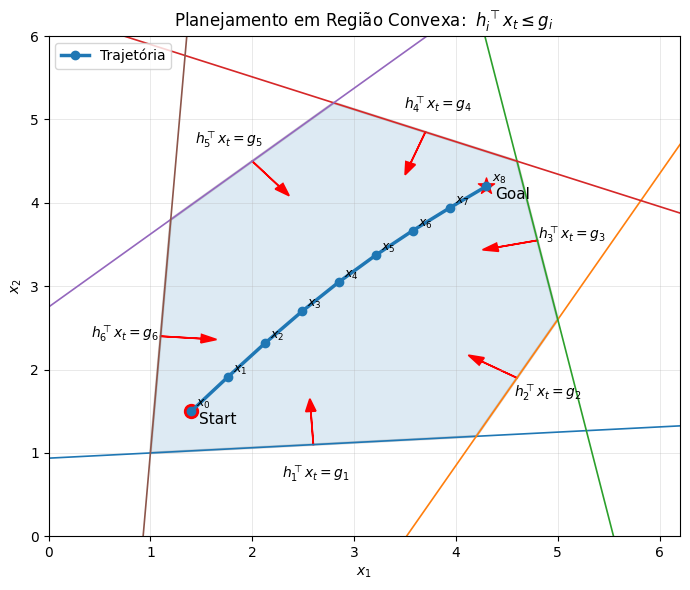

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def edge_normals_and_g(vertices):
    """
    Dado um polígono convexo (vértices em ordem anti-horária/CCW),
    retorna:
      - H: vetor normal unitário h_i de cada aresta (apontando para FORA do polígono)
      - G: escalar g_i tal que a reta da aresta é h_i^T x = g_i
      - centers: ponto médio de cada aresta (usado para desenhar setas/labels)

    Observação: para impor a região FECHADA (o interior do polígono),
    usamos h_i^T x <= g_i com h_i apontando para fora. Assim, o lado
    "viável" fica no sentido oposto ao normal h_i (isto é, -h_i aponta para dentro).
    """
    V = np.array(vertices, dtype=float)   # matriz (n, 2) com os vértices do polígono
    n = len(V)                            # número de vértices/arestas
    H, G, centers = [], [], []
    for i in range(n):
        p = V[i]                          # vértice atual
        q = V[(i+1) % n]                  # próximo vértice (com wrap)
        e = q - p                         # vetor da aresta (p -> q)
        # Normal "para fora" de polígono CCW: rotaciona e em +90°: (e_y, -e_x)
        nvec = np.array([e[1], -e[0]], dtype=float)
        norm = np.linalg.norm(nvec)       # norma da normal (comprimento)
        h = nvec / norm                   # h_i unitário
        g = float(h @ p)                  # g_i = h_i^T * p (ponto da própria aresta)
        H.append(h)
        G.append(g)
        centers.append((p + q) / 2.0)     # centro da aresta para posicionar setas/labels
    return np.array(H), np.array(G), np.array(centers)

def plot_halfspace_line(ax, h, g, xlim, ylim, **kwargs):
    """
    Desenha a reta h^T x = g no retângulo de visualização (xlim x ylim).
    Se b != 0 (h = [a, b]) isolamos y:
        y = (g - a x) / b
    Caso contrário (reta vertical), isolamos x:
        x = g / a
    """
    a, b = h
    xs = np.linspace(xlim[0], xlim[1], 200)
    ys = np.linspace(ylim[0], ylim[1], 200)
    if abs(b) > 1e-9:                     # caso geral: não-vertical
        y_line = (g - a*xs) / b
        ax.plot(xs, y_line, **kwargs)
    else:                                 # b ~ 0 -> reta vertical
        x_line = np.full_like(ys, g / a)
        ax.plot(x_line, ys, **kwargs)

# -------------------------------
# 1) Define um polígono convexo
#    (vértices CCW garantem normais para fora como definidas acima)
# -------------------------------
poly = np.array([
    [1.0, 1.0],
    [4.2, 1.2],
    [5.0, 2.6],
    [4.6, 4.5],
    [2.8, 5.2],
    [1.2, 3.8],
])

# Extrai (H, G) da representação por semi-espaços e centros das arestas
H, G, centers = edge_normals_and_g(poly)

# Pontos inicial (Start) e final (Goal) da trajetória
x_start = np.array([1.4, 1.5])
x_goal  = np.array([4.3, 4.2])

# -------------------------------
# 2) Constrói uma "trajetória segmentada"
#    - Interpolamos entre Start e Goal em 'num_segments'
#    - Pequena ondulação no y para ficar visualmente segmentado/curvo
# -------------------------------
num_segments = 8
xs = np.linspace(x_start[0], x_goal[0], num_segments+1)
ys = np.linspace(x_start[1], x_goal[1], num_segments+1)
ys += 0.2 * np.sin(np.linspace(0, np.pi, num_segments+1))  # ondinha suave
path_points = np.column_stack((xs, ys))                    # pontos [x_j] do caminho

# -------------------------------
# 3) Plot da região, restrições e trajetória
# -------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

# Preenche o polígono (região convexa) levemente transparente
ax.fill(poly[:,0], poly[:,1], alpha=0.15, edgecolor='black', linewidth=2)

# Janela de visualização
xlim = (0.0, 6.2)
ylim = (0.0, 6.0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# Para cada aresta: desenha a reta h_i^T x = g_i e a normal "para dentro"
for i, (h, g) in enumerate(zip(H, G), start=1):
    # Reta da restrição (fronteira do semi-espaço)
    plot_halfspace_line(ax, h, g, xlim, ylim, linewidth=1.2)

    # Ponto médio da aresta
    cx, cy = centers[i-1]

    # h aponta para fora; -h aponta para dentro (lado viável da desigualdade)
    h_inward = -h

    # Desenha uma seta curta apontando para o interior (visualiza o sentido de <=)
    normal_scale = 0.4
    ax.arrow(cx, cy,
             normal_scale*h_inward[0], normal_scale*h_inward[1],
             head_width=0.1, head_length=0.15,
             fc='red', ec='red', linewidth=1.2)

    # Coloca o rótulo da restrição *fora* do polígono (no sentido de h – para fora)
    outward = h
    label_offset = 0.35 * outward    # desloca o texto para fora
    # (h_offset não é usado no texto, mas pode ser útil p/ setas maiores)
    h_offset = 0.6 * outward         # mantido para referência/ajustes

    ax.text(cx + label_offset[0], cy + label_offset[1],
            rf"$h_{{{i}}}^\top x_t = g_{{{i}}}$",
            fontsize=10, ha='center', va='center')

# Desenha a trajetória segmentada com marcadores
ax.plot(path_points[:,0], path_points[:,1],
        color='tab:blue', linewidth=2.5, marker='o', label='Trajetória')

# Nomeia cada ponto do caminho como x_j
for j, (px, py) in enumerate(path_points):
    ax.text(px+0.05, py+0.05, rf"$x_{{{j}}}$", fontsize=9)

# Marcadores de Start e Goal
ax.scatter([x_start[0]], [x_start[1]], s=100, marker='o', color='red')
ax.text(x_start[0]+0.08, x_start[1]-0.15, "Start", fontsize=11)

ax.scatter([x_goal[0]], [x_goal[1]], s=150, marker='*', color='red')
ax.text(x_goal[0]+0.08, x_goal[1]-0.15, "Goal", fontsize=11)

# Legenda e rótulos de eixos
ax.legend(loc='upper left')
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title(r"Planejamento em Região Convexa: $\;h_i^\top x_t \leq g_i$")

# Grade e layout
ax.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()


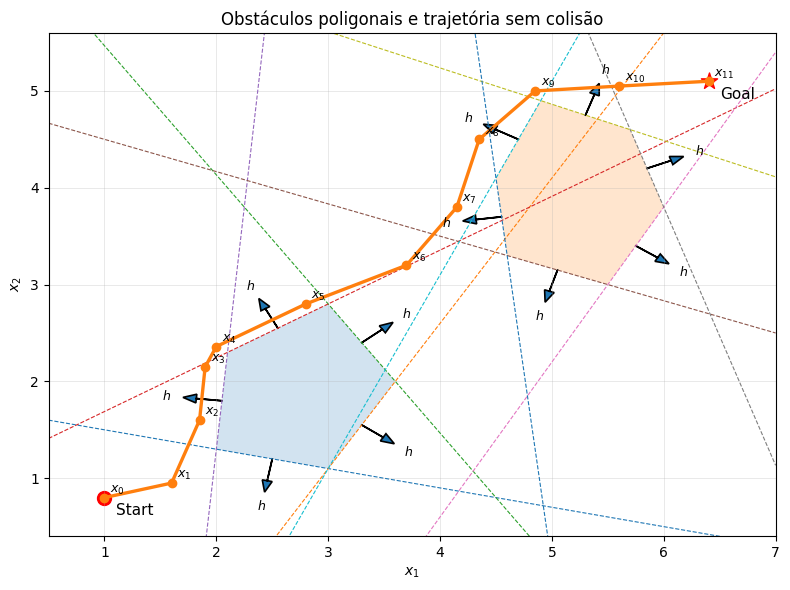

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def edge_normals_and_g(vertices):
    V = np.array(vertices, dtype=float)
    n = len(V)
    H, G, centers = [], [], []
    for i in range(n):
        p = V[i]
        q = V[(i+1) % n]
        e = q - p
        nvec = np.array([e[1], -e[0]], dtype=float)  # outward normal for CCW polygon
        norm = np.linalg.norm(nvec)
        h = nvec / norm
        g = float(h @ p)
        H.append(h)
        G.append(g)
        centers.append((p + q) / 2.0)
    return np.array(H), np.array(G), np.array(centers)

def plot_halfspace_line(ax, h, g, xlim, ylim, **kwargs):
    a, b = h
    xs = np.linspace(xlim[0], xlim[1], 300)
    ys = np.linspace(ylim[0], ylim[1], 300)
    if abs(b) > 1e-12:
        y_line = (g - a*xs) / b
        ax.plot(xs, y_line, **kwargs, linestyle='--')
    else:
        x_line = np.full_like(ys, g / a)
        ax.plot(x_line, ys, **kwargs, linestyle='--')

# Obstacles (CCW)
obs1 = np.array([
    [2.0, 1.3],
    [3.0, 1.1],
    [3.6, 2.0],
    [3.0, 2.8],
    [2.1, 2.3],
])

obs2 = np.array([
    [4.6, 3.3],
    [5.5, 3.0],
    [6.0, 3.8],
    [5.7, 4.6],
    [4.9, 4.9],
    [4.5, 4.1],
])

H1, G1, C1 = edge_normals_and_g(obs1)
H2, G2, C2 = edge_normals_and_g(obs2)

x_start = np.array([1.0, 0.8])
x_goal  = np.array([6.4, 5.1])

# New collision-free path including the waypoints, routed around obstacles
path_points = np.array([
    x_start,
    [1.6, 0.95],
    [1.85, 1.6],  
    [1.90, 2.15],
    [2.0, 2.36],           
    [2.8, 2.8], 
    [3.7, 3.2],
    [4.15, 3.8], 
    [4.35, 4.5],
    [4.85, 5.0],          
    [5.6, 5.05],
    x_goal
], dtype=float)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for obs, H, G, C in [(obs1, H1, G1, C1), (obs2, H2, G2, C2)]:
    ax.fill(obs[:,0], obs[:,1], alpha=0.2, linewidth=2)
    xlim = (0.5, 7.0)
    ylim = (0.4, 5.6)
    for h, g, center in zip(H, G, C):
        plot_halfspace_line(ax, h, g, xlim, ylim, linewidth=0.8)
        normal_scale = 0.35
        ax.arrow(center[0], center[1], normal_scale*h[0], normal_scale*h[1],
                 head_width=0.09, head_length=0.12, linewidth=1.2, length_includes_head=True)
        label_offset = 0.50 * h
        ax.text(center[0] + label_offset[0], center[1] + label_offset[1],
                r"$h$", fontsize=9, ha='center', va='center')

ax.plot(path_points[:,0], path_points[:,1], linewidth=2.4, marker='o')
for j, (px, py) in enumerate(path_points):
    ax.text(px+0.05, py+0.05, rf"$x_{{{j}}}$", fontsize=9)

ax.scatter([x_start[0]], [x_start[1]], s=100, marker='o', color='red')
ax.text(x_start[0]+0.1, x_start[1]-0.18, "Start", fontsize=11)

ax.scatter([x_goal[0]], [x_goal[1]], s=150, marker='*', color='red')
ax.text(x_goal[0]+0.1, x_goal[1]-0.18, "Goal", fontsize=11)

ax.set_xlim(0.5, 7.0)
ax.set_ylim(0.4, 5.6)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title(r"Obstáculos poligonais e trajetória sem colisão")
ax.grid(True, linewidth=0.4, alpha=0.5)

plt.tight_layout()
plt.show()


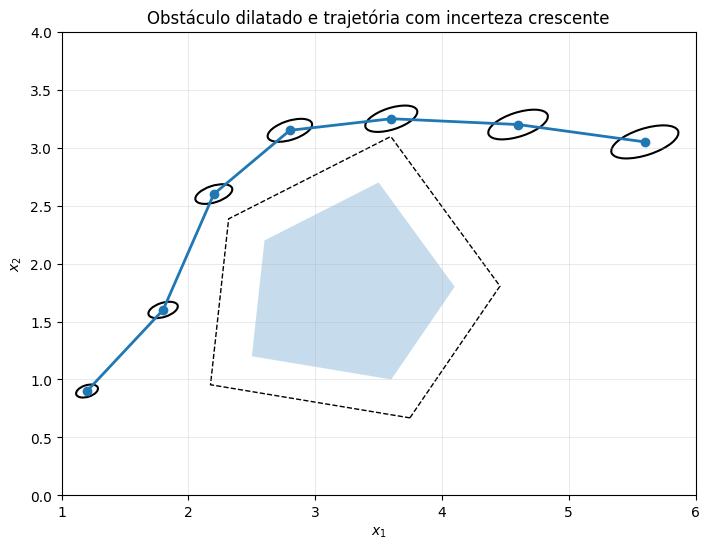

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Ellipse

def outward_unit_normals_and_g(vertices):
    V = np.asarray(vertices, dtype=float)
    n = len(V)
    H, G = [], []
    for i in range(n):
        p = V[i]
        q = V[(i+1) % n]
        e = q - p
        nvec = np.array([e[1], -e[0]], dtype=float)  # outward for CCW polygon
        nrm = np.linalg.norm(nvec)
        if nrm == 0:
            raise ValueError("Degenerate edge")
        h = nvec / nrm
        g = float(h @ p)
        H.append(h)
        G.append(g)
    return np.array(H), np.array(G)

def offset_polygon_by_halfspaces(H, G, r):
    n = len(G)
    verts = []
    for i in range(n):
        h1, g1 = H[i], G[i] + r
        h2, g2 = H[(i+1) % n], G[(i+1) % n] + r
        A = np.vstack([h1, h2])
        b = np.array([g1, g2])
        det = A[0,0]*A[1,1] - A[0,1]*A[1,0]
        if abs(det) < 1e-12:
            x = np.linalg.pinv(A) @ b
        else:
            x = np.linalg.solve(A, b)
        verts.append(x)
    return np.array(verts)

obs = np.array([
    [2.5, 1.2],
    [3.6, 1.0],
    [4.1, 1.8],
    [3.5, 2.7],
    [2.6, 2.2],
])

r = 0.3
H, G = outward_unit_normals_and_g(obs)
obs_off = offset_polygon_by_halfspaces(H, G, r)

path = np.array([
    [1.2, 0.9],
    [1.8, 1.6],
    [2.2, 2.6],
    [2.8, 3.15],
    [3.6, 3.25],
    [4.6, 3.20],
    [5.6, 3.05],
])

fig, ax = plt.subplots(figsize=(7.2, 5.6))
ax.add_patch(Polygon(obs, closed=True, alpha=0.25, lw=2))
ax.add_patch(Polygon(obs_off, closed=True, fill=False, ls='--', lw=1))

ax.plot(path[:,0], path[:,1], marker='o', lw=2)
#for j, (px, py) in enumerate(path):
#    ax.text(px+0.05, py+0.05, rf"$x_{{{j}}}$", fontsize=10)

base_w, base_h = 0.18, 0.10
growth = 0.35
angle = 20.0
for j, (px, py) in enumerate(path):
    w = base_w * (1 + growth*j)
    h = base_h * (1 + 0.6*growth*j)
    ell = Ellipse((px, py), width=w, height=h, angle=angle, fill=False, lw=1.5)
    ax.add_patch(ell)

ax.set_xlim(1.0, 6.0)
ax.set_ylim(0.0, 4.0)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("Obstáculo dilatado e trajetória com incerteza crescente")
ax.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()
